# Insights into Magnetic Resonance Imaging

## Simulation of Relaxation and Analysis of Influence of TR and TE on Differentiation of Long and Short T1/T2 Tissues


### Preparation of Environment

Execute the following code only if you are on Google Colab or similar and want to make the module `simtoolkit.py` available without manually installing it.

In [ ]:
!git clone https://github.com/dbonekamp/spin_simulation.git
import os
print(os.getcwd())
!cp -R ./spin_simulation/spin_simulation/simtoolkit .

### Start with Tutorial here


**Note:** You should have worked through the `spin_simulation.ipynb` before working on this Jupyter Notebook.

First we import the required libraries.
I have moved the simulation functions we reviewed in the last Jupyter Notebook to a separate module called `simtoolkit`. These functions have been revised and extended to reflect relaxation.
If you are interested, take a look at the implementation.

In [741]:
from importlib import reload  # Python 3.4+
import simtoolkit.simtoolkit as sim
sim = reload(sim)
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5) #if your plots turn out too large or small, adjust this


As before, we define some general properties of the physical environment we are simulating.

This includes the *Larmor Frequency*, which we set at the typical value for a 1.5 Tesla system.

The `offset_frequency` is the frequency the spins are noted to precess at, when viewed from the **rotating frame of reference**. 
We set this to the typical frequency offset of water at 4.7 ppm.

We then define a distribution of different frequencies, which are used to generate a Gaussian frequency distribution within our spin ensemble.
Importantly, this frequency distribution could be interpreted as many things:

- The distribution of frequencies within tissue
    - here, each spin object represents a different location in the tissue
- The distribution of frequencies in tissue caused by a linear external gradient field 
    - this is not our interpretation, as one should then model it using linear bins of same size, not as a gaussian distribution

If we wanted to simulate diffusion or perfusion, we would have to introduce a variable to store location and be able to change the location and local frequencies of spin objects.

These considerations may be regarded in future sessions.

Here, we focus on **relaxation**.

## Relaxation

The MR spin ensemble can relax in two different major ways:

- T1-Relaxation
A spin object tilted out of the equilibrium orientation along the z-axis will want to re-obtain that alignment.
This is simulated in the `simtoolkit` by calculating the difference vector between (0,0,magnitude) and the current spin object vector.
We allow the current magnetization by a certain preset percentage of that difference vector, such that it approximates the equilibrium state by reducing the distance vector by a constant proportion. This results in a closely enough exponential relaxation behaviour for our purposes.
We note that a vector tilted out of equilibrium by 180 degrees will relax by T1-relaxation without ever obtaining any xy-magnetization.

- T2-Relaxation
The individual spins within the spin ensemble lose phase coherence while they precess at different frequencies.
Note that this is the reason we have to simulate the frequency dispersion/distribution in our spin ensemble (if all spins had the same frequency, they would not dephase).
As we ignore diffusion for now and we simulate a static spin ensemble, in which spin object frequencies (and locations of modeled spins) do not change, we have pure T2-star (T2*) decay. Thus, the T2-prime (T2') component is missing and we can refocus all of the magnetization if we apply the correct pulse sequence.
Modeling T2' appears not neccessary for now, as it would introduce a dampening factor that would push the signal more into the noise floor, rather making our observations more difficult.
We simulate T2-relaxation by a process that was already necessary to simulate in our previous lecture, namely by **precession** of the spins. 

**Note:** If we want to simulate a tissue with longer T2 time, we would want to reduce the phase dispersion such that dephasing happens more slowly at the same influence of the physical environment. 
Thus, below, we will later have to adjust the `stdev_offset` to larger values for a tissue with shorter T2 time.

In [742]:
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.9e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

## Relaxation in Simulation

Let's look at an example how relaxation can be observed in this simulation.
Below, we generate a Spin object (note that we have to call the appropriate function from the `sim` module by prepending its name by `sim.`).
We then invert the spin magnetization by rotating it by 180 degrees.
We print the spin multiple times:

- The first time directly before rotation by 180 degrees
Its z-component is 1

- The second time directly after rotation by 180 degrees
Its z-component has become -1

- Then multiple times after relaxation for a pre-determined time of 200 msec
Observe how the z-magnetization slowly returns to 1

In [743]:
timepoints = []
z_magnetization = []
pulsetime = 20

s = sim.Spin(larmor_frequency, 1.0)
print(f"{s.toString()}")
z_magnetization.append(s.vector.value[2].round())
timepoints.append(0)
z_magnetization.append(z_magnetization[-1])
timepoints.append(pulsetime)

s.rotatex(np.deg2rad(180))
print(f"{s.toString()}")
z_magnetization.append(s.vector.value[2].round())
timepoints.append(pulsetime) # let's just say this happens at 400 msec
increment = 10
steps = 300
print_n_times = 10
printstep = round(steps/print_n_times)
for i in range(steps):
    s.relax(increment)
    if i%printstep==0:
        print(f"{s.toString()}")
    z_magnetization.append(s.vector.value[2])
    timepoints.append(timepoints[-1] + increment) # let's just say this happens at 400 msec


Frequency = 64000000.0, vector = (0.0, 0.0, 1.0), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, -1.0), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, -0.96), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, -0.06914927), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.41679584), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.68187128), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.82646577), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.9053398), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.94836434), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.97183356), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.98463565), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -0.0, 0.99161899), magnitude = 1.0


We have collected these z-magnetizations into a List called `z_magnetization`
Let's plot this.

See how the magnetization 'exponentially' relaxes back to 1.

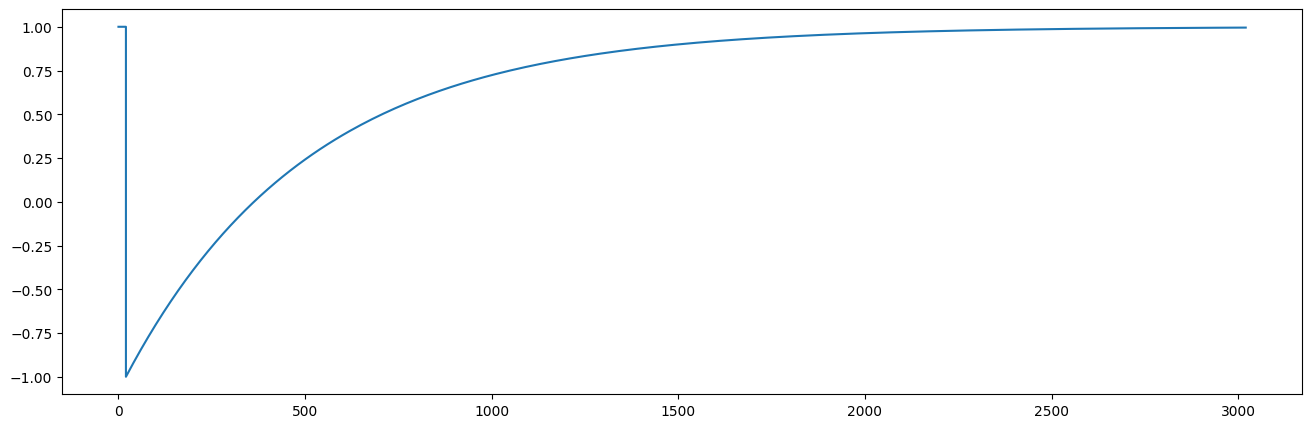

In [744]:
plt.plot(timepoints, z_magnetization)

## First Experiment

Now lets simulate a spin-echo pulse sequence, consisting of one *excitation pulse* of 90 degrees at 50 msec, and one *refocusing pulse* of 180 degrees at 1050 msec.

As we know, we might expect the echo at (1050-50)+1050 = 2050 msec.

To do so, we need to create a spin ensemble, of which we have to define the simulation quality.
The more spin we simulate, the better the result, but the longer the calculations take.
To make simulations faster, reduce the `number_spins` variable, or reduce the number of `timepoints`, either by simulating in a smaller time window, or with a smaller step size (below, the window is 0 to 3500, at a step size of 2).

In the last command, we set that we want to have relaxation in the model, and set the base relaxation rate. 
We will change this relaxation rate below in one of the ensembles to simulate tissues with different T1 relaxation.
A faster relaxation means a shorter T1 time of the simulated tissue.

We introduce a `frequency_dispersion_factor` to make the T2*-relaxation - related effects less fast (value less then one). This basically leads to line broadening of the peads in the next figure. 

### Exercise:
After having reviewed the graph, play with changes of the `frequency_dispersion_factor`

In [745]:
number_spins = 1500
timepoints = range(0,3500,2)
base_relaxation = 0.0005

frequency_dispersion_factor = 0.1

spins = sim.Spinensemble(number_spins, offset_frequency, stdev_offset*frequency_dispersion_factor)
spins.set_relaxation(base_relaxation)

After we have obtained our spin ensemble, we need to define the pulse sequence with the two pulses mentioned above.

In the last command, we run the simulation. If this takes too long, reduce the `number_spins` and increase the last value in the range above in the 2nd line.

In [746]:
pulseSequence = sim.PulseSequence()
pulseSequence.add(sim.Pulse("x-pulse", 50, 90))
pulseSequence.add(sim.Pulse("x-pulse", 1050, 180))

signal_list = pulseSequence.simulate(spins, timepoints)

  0%|          | 0/1749 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [01:14<00:00, 23.62it/s]


Let's now plot our results and interpret what we are seeing.

We see:
- At t=50 msec the 90 degree pulse (vertical line in magenta), labeled accordingly.
- At t=50 as well, the first *peak*, which is an FID, meaning that it starts from zero immediately to full magnetization and has a decreasing right lobe. This peak is labeled **A**
- Three lines/curves, which represent measurements of the total magnetization vector (one vector which is the vector sum of all spins in the ensemble)
    - The **transverse magnetization** (magnetization in the xy-plane = xy-magnetization) in blue. Note how we get a narrow FID right at the first pulse. Note already that we observe not much afterwards until the peak **B** at 2050 msec, the expected spin echo.
    - In *green*, the z-Magnetization. In the beginning, there is only z-magnetization. With the 90 degree pulse all z-magnetization is converted into xy-magnetization. Thus, at this point the green line goes from 1 to zero, while the blue curve goes from zero to 1. Afterwards, the z-mangnetization recovers slowly toward 1, note the ramp between 50 and 1050 msec. It is then inverted by the 180 degree pulse. So whatever value it had, it has the same absolute value but negative after the 180 degree pulse. From there, it slowly recovers by T1 relaxation crossing the zero line between 1500 and 2000 msec.
    - The *cyan* (light bluish) curve is the magnitude. This is the length of the magnetization.
- At 1050 msec, the refocusing pulse
- At 2050 msec, the spin echo

### Exercise:
Try to understand why the z-magnetization (green) and xy-magnetization (blue) behave like they do, in relationship to the pulses.
Unterstand the timing of the events.

Try to answer what aspects of this plot represent T1-relaxation, and which represent T2-relaxation.

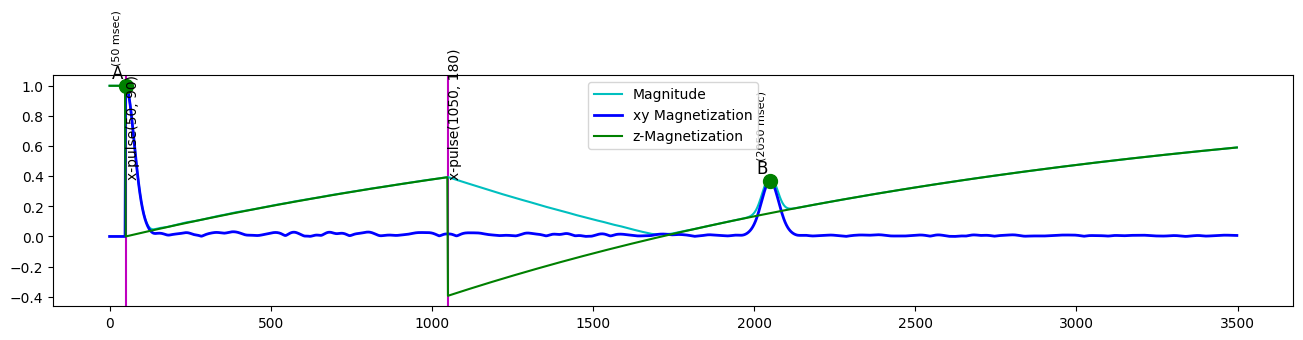

In [747]:
plt.rcParams["figure.figsize"] = (16, 3) #if your plots turn out too large or small, adjust this
pulseSequence.plotWithSignal(signal_list)
#pulseSequence.load(signal_list)
pulseSequence.determineHeightOfExpectedPeaks()
pulseSequence.showPeakLabels()
# print(pulseSequence.expected_peaks)

## Experiment 2: Simulation of different tissues and Sequences with different TR and TE Parameters

Let's now come to the main experiment.

We want to gain an understanding of how T1 and T2 times of different tissues interact with the sequence parameters **TR (repetition time)** and **TE (echo time)** of the MR sequence.

| TE/TR | TR short | TR long |
| --- | --- | --- |
| TE short | T1w | PDw |
| TE long | noise | T2w |

We focus in T2-weighted (T2w) and T1-weighted (T1w) sequences in our simulations. 
We first generate timepoints for the long TR and long TE sequence (T2w) and for the short TR and short TE sequence (T1w).
We use different timepoints, as the long TR requires us to watch a larger millisecond scale than the shorter TR, otherwise one of the graphs would show too many or too few repetitions.

Create Spin Ensembles for both situations and set the relaxation differently. This way, we obtain spins with a different phase dispersion and a different relaxation rate (T1-relaxation). 

- One tissue is the long T1 and long T2 tissue
e.g. Water
- the other the short T1 and T2 tissue.
e.g. Fat

In [748]:
high_res = True
if high_res:
    number_spins = 5000
    timepoints_longTR_longTE = range(0,8000,5)
    timepoints_shortTR_shortTE = range(0,800,1)
else:
    number_spins = 1000
    timepoints_longTR_longTE = range(0,8000,12)
    timepoints_shortTR_shortTE = range(0,800,2)

base_relaxation = 0.0005

spins_long_T1_T2 = sim.Spinensemble(number_spins, offset_frequency, stdev_offset)
spins_long_T1_T2.set_relaxation(base_relaxation)

TR_factor = 12.0
TE_factor = 3.0
spins_short_T1_T2 = sim.Spinensemble(number_spins, offset_frequency, stdev_offset*TE_factor)
spins_short_T1_T2.set_relaxation(base_relaxation*TR_factor)

Now we create a suitable long TR and long TR pulse sequence.

### Exercise:
Think about the choices that were made for the time positions of the pulses

Note that we use a **crusher gradient**, which strongly dephases the spins. Look at the implementation in the simtoolkit if interested.
This *crusher gradient* destroys all the transverse magnetization and leaves only the z-magnetization intact.

Without the *crusher gradient*, spin history would accumulate and we would observe signal accumulation, which opposes our intent to control the signal by TE and TR.

### Exercise:
After you revieved this entire example, remove the crusher gradients (e.g. by commenting the line by putting a hash (#) in front). Observe the signal behaviour.

We now simulate the signal for the first situation, the long TR and long TE sequence, on both spin ensembles (for long T1/T2 and short T1/T2).
If this takes too long, reduce the resolution as explained in the previous example.

In [749]:
pulseSequence_longTR_longTE = sim.PulseSequence()
pulseSequence_longTR_longTE.add(sim.Pulse("x-pulse", 10, 90))
pulseSequence_longTR_longTE.add(sim.Pulse("x-pulse", 410, 180)) #echo expected at 810
pulseSequence_longTR_longTE.add(sim.Pulse("crusher", 1800, 19159)) #crusher gradient
pulseSequence_longTR_longTE.setTR(2000)
signalList_long_T1_T2_longTR_longTE = pulseSequence_longTR_longTE.simulate(spins_long_T1_T2, timepoints_longTR_longTE)
signalList_short_T1_T2_longTR_longTE = pulseSequence_longTR_longTE.simulate(spins_short_T1_T2, timepoints_longTR_longTE)

100%|██████████| 1599/1599 [03:37<00:00,  7.34it/s]


We run the simulations for the short TR and TE sequence. We finish all the simulations first so we can look at the results side-by-side.

In [750]:
pulseSequence_shortTR_shortTE = sim.PulseSequence()
pulseSequence_shortTR_shortTE.add(sim.Pulse("x-pulse", 10, 90))
pulseSequence_shortTR_shortTE.add(sim.Pulse("x-pulse", 50, 180)) #echo expected at 90
pulseSequence_shortTR_shortTE.add(sim.Pulse("crusher", 120, 19159)) #crusher gradient
pulseSequence_shortTR_shortTE.setTR(140)
signalList_long_T1_T2_shortTR_shortTE = pulseSequence_shortTR_shortTE.simulate(spins_long_T1_T2, timepoints_shortTR_shortTE)
signalList_short_T1_shortTR_shortTE = pulseSequence_shortTR_shortTE.simulate(spins_short_T1_T2, timepoints_shortTR_shortTE)

100%|██████████| 799/799 [01:48<00:00,  7.35it/s]


### The long TR, long TE sequence (T2-weighted)

In the Figure below, we observe a stabilization phase in the beginning. 

### Top: long T1 and T2 time tissue
After equilibrium is reached, the signal of the spin echoes is substantial, e.g. echoes **D**, **F** and **H**. Remember, the blue curve represents the signal measurable by the MR scanner, the transverse magnetization.

Tissue with a long T1 and T2 time therefore obtains *high signal* within a long TR and long TE sequence.

### Exercise:
Explain to each other why this is the case, using the figure.

### Bottom: short T1 and T2 time tissue
The signal of the spin echoes is essentially absent. Expected positions are marked with red dots.

Tissue with a short T1 and T2 time therefore obtains *low signal* within a long TR and long TE sequence.

### Exercise:
Explain to each other why this is the case, using the figure.


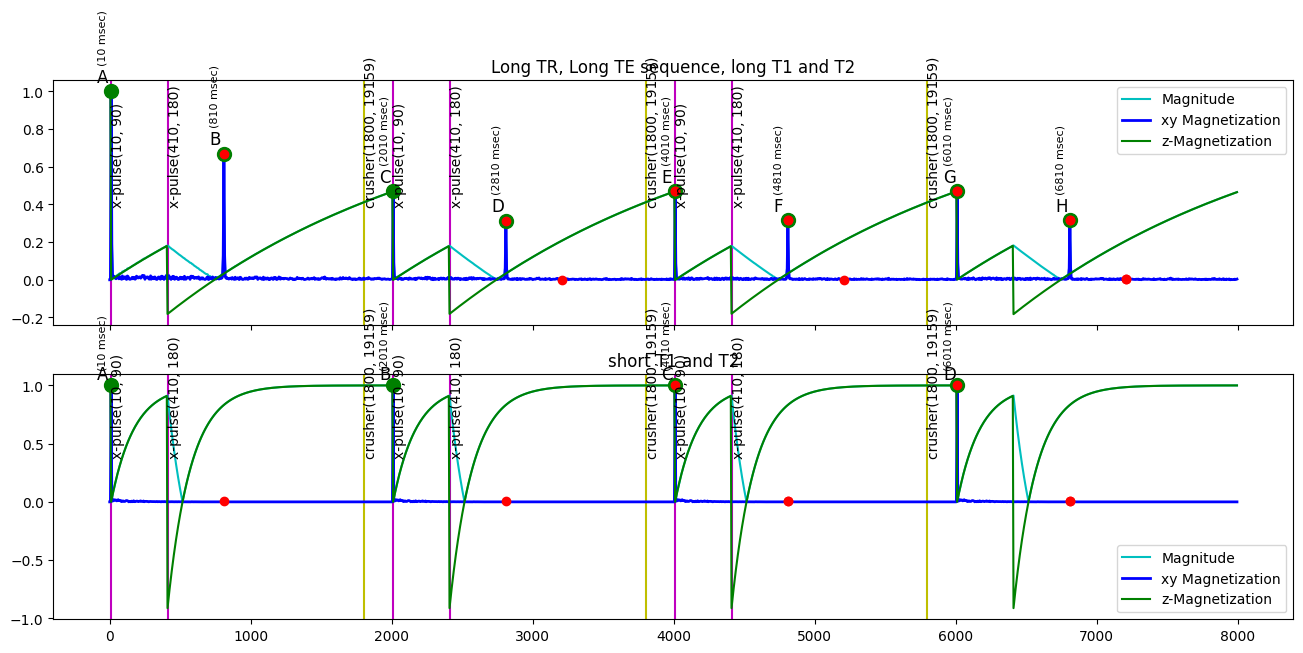

In [751]:
plt.rcParams["figure.figsize"] = (16, 7) #if your plots turn out too large or small, adjust this

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Long TR, Long TE sequence, long T1 and T2')
ax2.set_title('short T1 and T2')

pulseSequence_longTR_longTE.setAx(ax1)
pulseSequence_longTR_longTE.plotWithSignal(signalList_long_T1_T2_longTR_longTE)
pulseSequence_longTR_longTE.load(signalList_long_T1_T2_longTR_longTE)
pulseSequence_longTR_longTE.determineHeightOfExpectedPeaks()
pulseSequence_longTR_longTE.showPeakLabels()
pulseSequence_longTR_longTE.showExpectedPeaks(text = False)

pulseSequence_longTR_longTE.setAx(ax2)
pulseSequence_longTR_longTE.plotWithSignal(signalList_short_T1_T2_longTR_longTE)
pulseSequence_longTR_longTE.load(signalList_short_T1_T2_longTR_longTE)
pulseSequence_longTR_longTE.determineHeightOfExpectedPeaks()
pulseSequence_longTR_longTE.showPeakLabels()
pulseSequence_longTR_longTE.showExpectedPeaks(text = False)


### The short TR, short TE sequence (T1-weighted)

In the Figure below, we observe a stabilization phase in the beginning. 

### Top: long T1 and T2 time tissue
After equilibrium is reached, the signal of the spin echoes is essentially absent. Even the FIDs after application of the excitation pulses are essentially absent.

Tissue with a long T1 and T2 time therefore obtains *low signal* within a long TR and long TE sequence.

### Exercise:
Explain to each other why this is the case, using the figure.

### Bottom: short T1 and T2 time tissue
The signal of the spin echoes is well measurable, represented by the peaks **D**, **F**, **H**, **J** and **L**.

Tissue with a short T1 and T2 time therefore obtains *high signal* within a long TR and long TE sequence.

### Exercise:
Explain to each other why this is the case, using the figure.

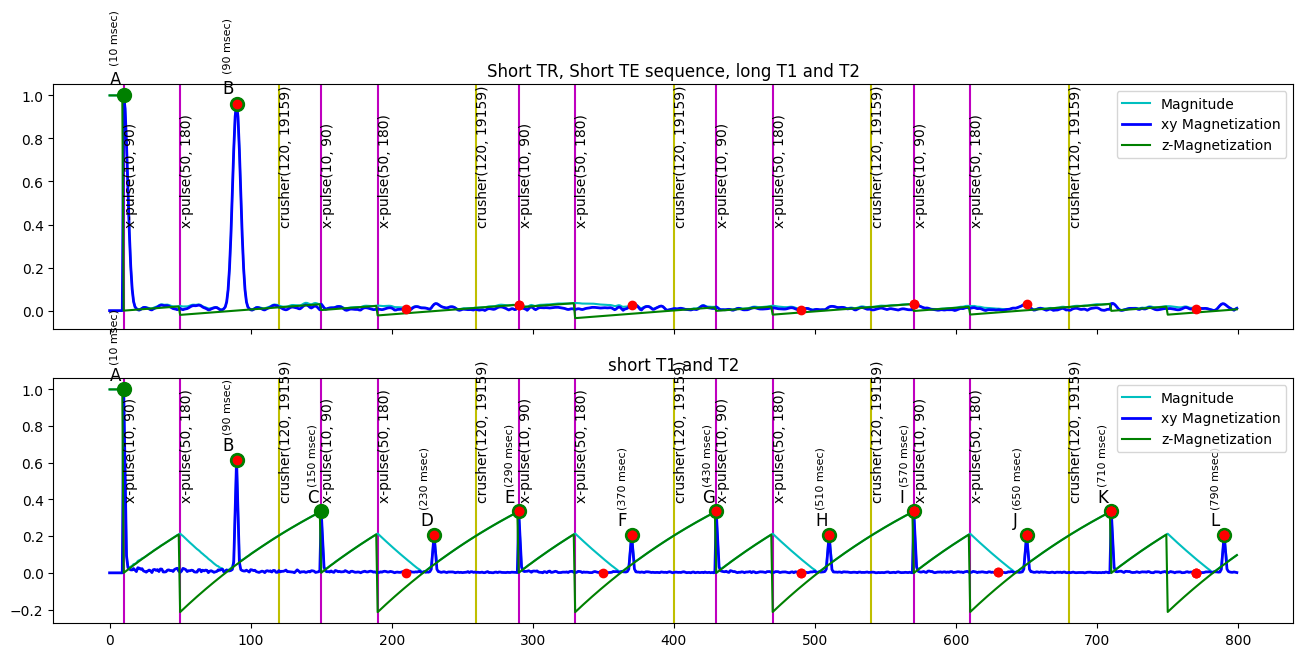

In [752]:
plt.rcParams["figure.figsize"] = (16, 7) #if your plots turn out too large or small, adjust this

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Short TR, Short TE sequence, long T1 and T2')
ax2.set_title('short T1 and T2')

pulseSequence_shortTR_shortTE.setAx(ax1)
pulseSequence_shortTR_shortTE.plotWithSignal(signalList_long_T1_T2_shortTR_shortTE)
pulseSequence_shortTR_shortTE.load(signalList_long_T1_T2_shortTR_shortTE)
pulseSequence_shortTR_shortTE.determineHeightOfExpectedPeaks()
pulseSequence_shortTR_shortTE.showPeakLabels()
pulseSequence_shortTR_shortTE.showExpectedPeaks(text = False)

pulseSequence_shortTR_shortTE.setAx(ax2)
pulseSequence_shortTR_shortTE.plotWithSignal(signalList_short_T1_shortTR_shortTE)
pulseSequence_shortTR_shortTE.load(signalList_short_T1_shortTR_shortTE)
pulseSequence_shortTR_shortTE.determineHeightOfExpectedPeaks()
pulseSequence_shortTR_shortTE.showPeakLabels()
pulseSequence_shortTR_shortTE.showExpectedPeaks(text = False)


## Summary

Now you have simulated relaxation of spins within the environment of different MR sequences.

This has given you insights into physical simulations using Pyton, graphical display of signal-time curves using Matplotlib and vector algebra.

The models we used are approximating reality to some degree, however do not give a complete picture. 

One aspect that is not modeled here is actual T2-decay. As in the absence of T1-Relaxation, the transverse magnetization would always be restored to 1 with 180 degree refocusing pulses, this mechanism is not implemented. There is some effect of T1-Relaxation on transverse magnetization as modeled here. We use variation of phase dispersion to model T2* differences, however these are not essential to understand the T1 and T2 characteristics of the tissue. We take it as a sufficient modeling level that the transverse magnetization is affected by T1-relaxation such that long T1/T2 and short T1/T2 behaviour can be approximated.

For the interested: think how a better simulation of T1- and T2-relaxation could be implemented.

Note the formula:

$$
\frac{1}{T2^{*}} = \frac{1}{T2} + \frac{1}{T2^{\prime}}
$$

### Exercise:

Change the code above or copy it to generate short TE/long TR (proton density weighted = PDw) and long TE/short TR (low signal-to-noise) sequences and oberve the characteristics, and make sure our simulation can handle these sequence types. Find fitting parameter settings.